In [1]:
import sys
sys.path.append('/Users/huangxingyue/Desktop/NYU MFE/12 Capstone')
import numpy as np
import pandas as pd
import math
from Pricing.MC_simulation import simulateSABRMonteCarloEuler, simulateSABRMonteCarloMilstein, drawTwoRandomNumbers
from Fitter.fitter import Fitter
from Pricing.BS import black, dPlusBlack, dMinusBlack, find_ivol
from matplotlib import pyplot as plt

In [2]:
fitter=Fitter('market_data.xlsx')
results=fitter.calibration() #Hagan lognormal implementation
ivols=fitter.ivol_SABR(results['alpha'],results['beta'],results['rho'],results['nu'])
params=results['params']

### Take swaption of 5Y tenor and 10Y expiry as an example

In [3]:
factors=params.loc[13,:][2:]
vols=ivols.loc[13,:]
print ('params:\n', factors)
print ('ivols:\n', vols)

('params:\n', F        0.033460
alpha    0.020476
beta     0.311017
rho     -0.102919
nu       0.311203
Name: 13, dtype: float64)
('ivols:\n', tenor      5.000000
expiry    10.000000
F          0.033460
-150       0.311059
-100       0.274397
-50        0.248384
-25        0.238508
0          0.230400
25         0.223851
50         0.218662
100        0.211611
150        0.207853
Name: 13, dtype: float64)


In [4]:
# Run Monte-Carlo simulation under Euler scheme and Milstein scheme
forwards1=simulateSABRMonteCarloEuler(100000,40, 10, vols['F'], 0.0071957323083426811,0,0,0.25)
forwards2=simulateSABRMonteCarloMilstein(100000,40, 10, vols['F'],0.0071957323083426811,0,0,0.25)

In [5]:
print np.mean(forwards1),np.mean(forwards2)

0.0334997738392 0.0335497212334


In [6]:
p1=[] #MC simulated option price
p2=[] #BS predicted price by Hagan lognormal
for K_spread in vols.index.tolist()[3:]:
    option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
    p1.append(sum(option)/len(option))
    p2.append(black(vols['F'],(vols['F']+K_spread/10000.),10,vols[K_spread],1))

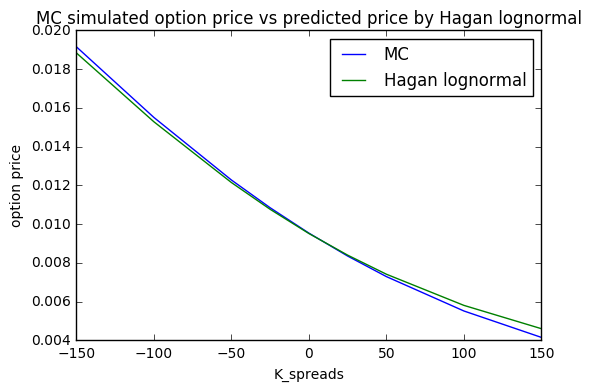

In [7]:
plt.plot(vols.index.tolist()[3:],p1,label='MC')
plt.plot(vols.index.tolist()[3:],p2,label='Hagan lognormal')
plt.title('MC simulated option price vs predicted price by Hagan lognormal')
plt.xlabel('K_spreads')
plt.ylabel('option price')
plt.legend()
plt.show()

In [8]:
ivols_hagan=vols.values[3:]
ivols_MC=[]
for counter, K_spread in enumerate(vols.index.tolist()[3:]):
    ivols_MC.append(find_ivol(p1[counter],vols['F'],vols['F']+K_spread/10000.,10))

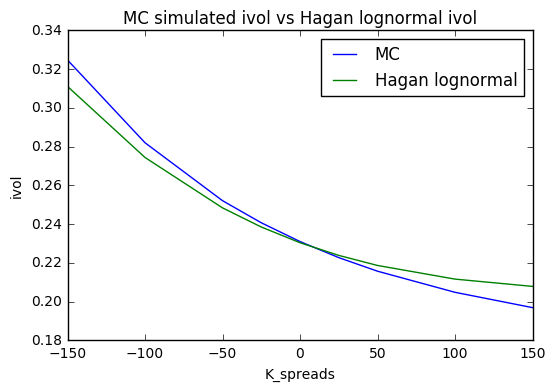

In [9]:
plt.plot(vols.index.tolist()[3:],ivols_MC,label='MC')
plt.plot(vols.index.tolist()[3:],ivols_hagan,label='Hagan lognormal')
plt.title('MC simulated ivol vs Hagan lognormal ivol')
plt.xlabel('K_spreads')
plt.ylabel('ivol')
plt.legend()
plt.show()

### Analysis of simulation result

In [12]:
ivol_sim=pd.read_excel('../Documentation/SABR_report.xlsx')
ivol_sim=ivol_sim.iloc[3:,1:]

In [13]:
error=[]
#for j in [1,7,13,19,25]:
#for j in [36,42,48,54,60]:
for j in [36+35,42+35,48+35,54+35,60+35]:
    temp=[]
    for i in range(1,10):
        temp.append(np.std(ivol_sim.iloc[j:j+4,i].values))
    error.append(np.mean(temp))

In [14]:
print (error)
print (np.mean(error))

[0.059375630317443383, 0.11229245503115066, 0.050904784896088795, 0.087749279180916212, 0.18270548007863244]
0.0986055259008


### ATM ivol recovery for MC simulation

In [15]:
from scipy.optimize import minimize
from Pricing.SABR import SABR_model

def objfunc_atm(alpha,beta,rho,nu,F,expiry,MKT,method='Hagan_ln'):
    sabr = SABR_model(beta,rho,nu)
    if method=='Hagan_ln':
        res=(sabr.ivol_Hagan_ln(alpha,F,F,expiry)-MKT)**2
    elif method=='Hagan_norm':
        res=(sabr.ivol_Hagan_norm(alpha,F,F,expiry)-MKT)**2
    elif method=='Obloj':
        res=(sabr.ivol_Obloj(alpha,F,F,expiry)-MKT)**2
    return res

In [17]:
res = minimize(objfunc_atm,0, (0,0,0.25,vols['F'],10,vols[0]))
res.x[0]

0.0071957739129445966